In [111]:
from IPython.display import Audio
import librosa
from librosa import display
import numpy as np
import scipy
from matplotlib import pyplot as plt
import os
import pandas as pd
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
plt.style.use('ggplot')
%matplotlib inline

/home/maria/Programs/anaconda3/lib/python3.6/site-packages/matplotlib/backends/__init__.py:60: MatplotlibDeprecationWarning: matplotlib.verbose is deprecated;
Command line argument --verbose-LEVEL is deprecated.
This functionality is now provided by the standard
python logging library.  To get more (or less) logging output:
    import logging
    logger = logging.getLogger('matplotlib')
    logger.set_level(logging.INFO)
  # imports. 0 means only perform absolute imports.
/home/maria/Programs/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:356: MatplotlibDeprecationWarning: matplotlib.verbose is deprecated;
Command line argument --verbose-LEVEL is deprecated.
This functionality is now provided by the standard
python logging library.  To get more (or less) logging output:
    import logging
    logger = logging.getLogger('matplotlib')
    logger.set_level(logging.INFO)
  if self.ge(level):


In [170]:
WAV_DIR = 'wav_files/'
wav_files = os.listdir(WAV_DIR)[:]   # originally only 10 files were used

In [171]:
col_names = ['file_name', 'signal_mean', 'signal_std', 'signal_skew', 'signal_kurtosis', 
             'zcr_mean', 'zcr_std', 'rmse_mean', 'rmse_std', 'tempo',
             'spectral_centroid_mean', 'spectral_centroid_std',
             'spectral_bandwidth_2_mean', 'spectral_bandwidth_2_std',
             'spectral_bandwidth_3_mean', 'spectral_bandwidth_3_std',
             'spectral_bandwidth_4_mean', 'spectral_bandwidth_4_std'] + \
            ['spectral_contrast_' + str(i+1) + '_mean' for i in range(7)] + \
            ['spectral_contrast_' + str(i+1) + '_std' for i in range(7)] + \
            ['spectral_rolloff_mean', 'spectral_rolloff_std'] + \
            ['mfccs_' + str(i+1) + '_mean' for i in range(20)] + \
            ['mfccs_' + str(i+1) + '_std' for i in range(20)] + \
            ['chroma_stft_' + str(i+1) + '_mean' for i in range(12)] + \
            ['chroma_stft_' + str(i+1) + '_std' for i in range(12)] 
            
df = pd.DataFrame(columns=col_names)

In [172]:
for f in tqdm(wav_files[:]):    # originally only 10 files were used
    try:
        # Read wav-file
        y, sr = librosa.load(WAV_DIR+f, sr = 22050)
        
        feature_list = [f]

        feature_list.append(np.mean(abs(y)))
        feature_list.append(np.std(y))
        feature_list.append(scipy.stats.skew(abs(y)))
        feature_list.append(scipy.stats.kurtosis(y))

        zcr = librosa.feature.zero_crossing_rate(y + 0.0001, frame_length=2048, hop_length=512)[0]
        feature_list.append(np.mean(zcr))
        feature_list.append(np.std(zcr))

        rmse = librosa.feature.rmse(y + 0.0001)[0]
        feature_list.append(np.mean(rmse))
        feature_list.append(np.std(rmse))
        
        tempo = librosa.beat.tempo(y, sr=sr)
        feature_list.extend(tempo)

        spectral_centroids = librosa.feature.spectral_centroid(y+0.01, sr=sr)[0]
        feature_list.append(np.mean(spectral_centroids))
        feature_list.append(np.std(spectral_centroids))

        spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=2)[0]
        spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=3)[0]
        spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=4)[0]
        feature_list.append(np.mean(spectral_bandwidth_2))
        feature_list.append(np.std(spectral_bandwidth_2))
        feature_list.append(np.mean(spectral_bandwidth_3))
        feature_list.append(np.std(spectral_bandwidth_3))
        feature_list.append(np.mean(spectral_bandwidth_3))
        feature_list.append(np.std(spectral_bandwidth_3))

        spectral_contrast = librosa.feature.spectral_contrast(y, sr=sr, n_bands = 6, fmin = 200.0)
        feature_list.extend(np.mean(spectral_contrast, axis=1))
        feature_list.extend(np.std(spectral_contrast, axis=1))

        spectral_rolloff = librosa.feature.spectral_rolloff(y+0.01, sr=sr, roll_percent = 0.85)[0]
        feature_list.append(np.mean(spectral_rolloff))
        feature_list.append(np.std(spectral_rolloff))

        mfccs = librosa.feature.mfcc(y, sr=sr, n_mfcc=20)
        feature_list.extend(np.mean(mfccs, axis=1))
        feature_list.extend(np.std(mfccs, axis=1))

        chroma_stft = librosa.feature.chroma_stft(y, sr=sr, hop_length=1024)
        feature_list.extend(np.mean(chroma_stft, axis=1))
        feature_list.extend(np.std(chroma_stft, axis=1))
        
        feature_list[1:] = np.round(feature_list[1:], decimals=3)
        
    except:
        pass
    
    df = df.append(pd.DataFrame(feature_list, index=col_names).transpose(), ignore_index=True)
    df_archive = df


100%|██████████| 5125/5125 [44:36<00:00,  1.92it/s]


## Remove vague classes

In [168]:
print (df.shape)
label_dict = {  'Background_music':0,
    'Theme_music':1,
    'Jingle':2,
    'Soundtrack_music':3,
    'Lullaby':4,
    'Video_game_music':5,
    'Christmas_music':6,
    'Dance_music':7,
    'Wedding_music':8}
    # 'Birthday_music':9} 
to_remove = [0]

df['label'] = df['file_name'].apply(lambda x: label_dict[x[:-4].split('_', 1)[1]])

for l in to_remove:
    df = df[df['label'] != l]

# del(df['label'])
print (df.shape)
    
df.head()

(4560, 99)
(4560, 99)


,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std,label
0,22564_Wedding_music.wav,0.115,0.151,1.317,0.716,0.07,0.052,0.145,0.042,129.199,...,0.203,0.293,0.194,0.246,0.248,0.276,0.375,0.271,0.35,8
1,2170_Wedding_music.wav,0.1,0.13,1.386,0.845,0.063,0.013,0.125,0.038,99.384,...,0.219,0.378,0.177,0.295,0.146,0.229,0.356,0.206,0.285,8
2,12235_Dance_music.wav,0.377,0.449,0.377,-0.866,0.055,0.039,0.44,0.088,129.199,...,0.219,0.291,0.283,0.26,0.271,0.307,0.322,0.291,0.294,7
3,4743_Dance_music.wav,0.092,0.12,1.304,0.651,0.128,0.051,0.115,0.032,151.999,...,0.361,0.272,0.322,0.197,0.358,0.253,0.236,0.343,0.197,7
4,17151_Wedding_music.wav,0.192,0.244,1.151,0.294,0.083,0.016,0.236,0.059,92.285,...,0.192,0.385,0.109,0.133,0.103,0.186,0.233,0.138,0.371,8


## Vizualizing features (T-SNE)

Visualizing obtained features using T-SNE. Because the full feature space has high dimentionality (97), PCA is performed first. 

In [165]:
%%time

n_comp = 60

pca = PCA(n_components=n_comp)
pca_result = pca.fit_transform(df[df.columns[1:-1]].values)

print ('Cumulative explained variation for ' + str(n_comp) + ' principal components: ' 
       + str(round(np.sum(pca.explained_variance_ratio_), 4)*100) + '%')

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result) # exclude name column

Cumulative explained variation for 60 principal components: 100.0%
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4560 samples in 0.006s...
[t-SNE] Computed neighbors for 4560 samples in 0.368s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4560
[t-SNE] Computed conditional probabilities for sample 2000 / 4560
[t-SNE] Computed conditional probabilities for sample 3000 / 4560
[t-SNE] Computed conditional probabilities for sample 4000 / 4560
[t-SNE] Computed conditional probabilities for sample 4560 / 4560
[t-SNE] Mean sigma: 123.596124
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.457466
[t-SNE] Error after 300 iterations: 1.692572
CPU times: user 23 s, sys: 1.34 s, total: 24.3 s
Wall time: 21.8 s


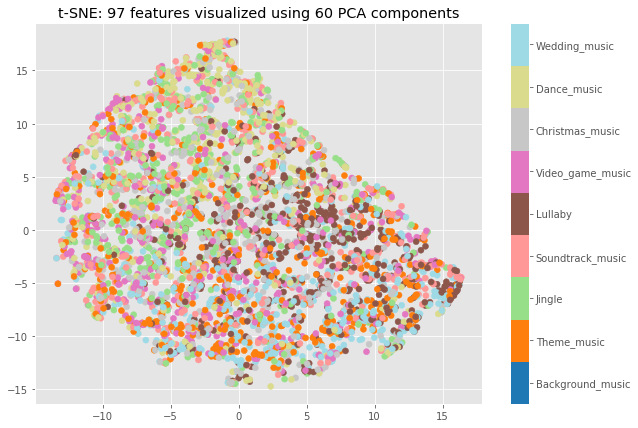

In [166]:
label_dict = {  'Background_music':0,
                'Theme_music':1,
                'Jingle':2,
                'Soundtrack_music':3,
                'Lullaby':4,
                'Video_game_music':5,
                'Christmas_music':6,
                'Dance_music':7,
                'Wedding_music':8}
# df['label'] = df['file_name'].apply(lambda x: label_dict[x[:-4].split('_', 1)[1]])

df_tsne = df.copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

plt.figure(figsize=(10,7))
plt.title('t-SNE: 97 features visualized using ' + str(n_comp) + ' PCA components')
plot = plt.scatter(df_tsne['x-tsne'], df_tsne['y-tsne'], c=df_tsne['label'], cmap=plt.cm.get_cmap("tab20", 9))
cbar = plt.colorbar(ticks=range(9))
cbar.set_ticklabels(list(label_dict.keys()))

plt.clim(-0.5, 8.5)

plt.show()

Final feature formulation and saving to file:

In [167]:
# features
col_names = ['pca_' + str(i+1) for i in range(n_comp)] # ['file_name'] + \
            
#df_pca = pd.DataFrame(columns=col_names)
# print (pca_result)

df_pca = pd.DataFrame(data=pca_result)
df_pca.columns = col_names
df_pca.insert(0, 'file_name', df['file_name'])

# Save file
df_pca.to_csv('extracted_features/df_features_pca.csv', index=False)

df_pca.head()

,file_name,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_51,pca_52,pca_53,pca_54,pca_55,pca_56,pca_57,pca_58,pca_59,pca_60
0,22564_Wedding_music.wav,-638.283743,797.760300,-104.791661,-40.640350,43.685622,-21.852234,-97.658862,4.003027,-15.659688,...,1.120721,-0.628025,-1.298481,2.057688,1.017574,-0.481963,-0.161318,1.264022,-0.325472,0.320518
1,2170_Wedding_music.wav,-2252.688348,-223.837713,-131.680587,45.288983,77.990478,69.176620,-21.222539,9.563729,0.438047,...,1.205281,0.327043,-0.350518,0.075465,1.139012,0.180213,0.831102,0.632054,0.390715,0.818182
2,12235_Dance_music.wav,2038.545816,116.487616,-172.756628,-79.590050,-60.919398,-83.415731,-113.587213,-30.380727,0.173788,...,1.316422,-0.140328,0.592188,0.786408,0.650101,0.170685,-1.026900,-0.299049,0.650272,-0.025711
3,4743_Dance_music.wav,1656.999493,-114.807179,33.856087,-60.341633,-60.823697,56.789022,50.566851,16.062891,-2.680556,...,0.572856,-0.605472,-1.419425,1.298980,0.432158,0.508419,-0.178374,-0.162710,0.476347,-0.369380
4,17151_Wedding_music.wav,-1891.144495,-916.624239,195.197957,-12.865184,46.986571,110.621889,-44.145420,24.258285,43.876532,...,0.600837,-0.756884,0.671616,-0.643474,-1.840740,0.671540,-0.232468,-0.040159,0.636269,-0.211106
